## Connecting to Presto

Presto ships with a CLI. Run `docker exec -it classroom-presto_presto_1 bin/presto-cli` do access it from the Presto container. the Presto CLI supports autocompletion, history, progress bars and other useful features. For quickly testing queries the CLI is very helpful.

In a environment like a Jupyter notebook, we can use a Presto Python client. The Presto client library implements the Python DBAPI2.0 interface that is used by common database client libraries for querying MySQL, PostgreSQL and SQLite.

DBAPI2.0 defines a API with a `Connection`. Queries then happen with a `cursor`. Presto supports transaction. The level of isolation depends on the connectors involved in a query.

The three mandatory arguments to create a connection are *host*, *port*, and *user*.
Other arguments such as *source* allow to identify the origin of the query. A common use case is to use it to tell which service, tool, or code sent the query.

Let's create a connection:

In [11]:
import prestodb.dbapi as presto
from pydrill.client import PyDrill

drill = PyDrill(host='drill', port=8047)

if not drill.is_active():
    raise ValueError('Please run Drill first')

conn = presto.Connection(host="presto", port=8080, user="demo")
cur = conn.cursor()
cur

## Configuration

Presto's general configuration is documented in the [deployment](https://prestodb.github.io/docs/current/installation/deployment.html) page. There are 4 types of configuration files:
- Node Properties: to configure the coordinator (main server) and worker nodes.
- JVM Config: command line options for the Java Virtual Machine that runs Presto.
- Config Properties: configuration for the Presto server
- Catalog Properties: configuration for Connectors (data sources)

In the repository, the configuration is in `etc/`. The main file to configure Presto is `config.properties`:

```
coordinator=true
node-scheduler.include-coordinator=true
http-server.http.port=8080
discovery-server.enabled=true
discovery.uri=http://localhost:8080
```

The discovery is what allows worker nodes to find the coordinator and register themselves. Then they will participate in the execution of queries.

## Catalogs

A catalog is mapped to a connector. The name of configuration file for a catalgo defines the catalog's name. Here `etc/catalog/mysql.properties` configures the `mysql` catalog. We could name it `events` or `users`:

```
connector.name=mysql
connection-url=jdbc:mysql://mysql:3306
connection-user=USER
connection-password=PASSWORD
```

We did the same with `etc/catalog/mongodb.properties`:

```
connector.name=mongodb
mongodb.seeds=mongodb
```

Adding a catalog is a simple as adding a file with the catalog properties and named after the catalog's name.


Below we list the available catalogs on the Presto cluster we are running:

In [3]:
cur.execute("SHOW catalogs")
cur.fetchall()

[['hive'], ['mongodb'], ['mysql'], ['system'], ['tcph']]

## How Does Presto Execute a Query?

If you are curious about what Presto translate a SQL query to and what it will run, you can you `EXPLAIN`:

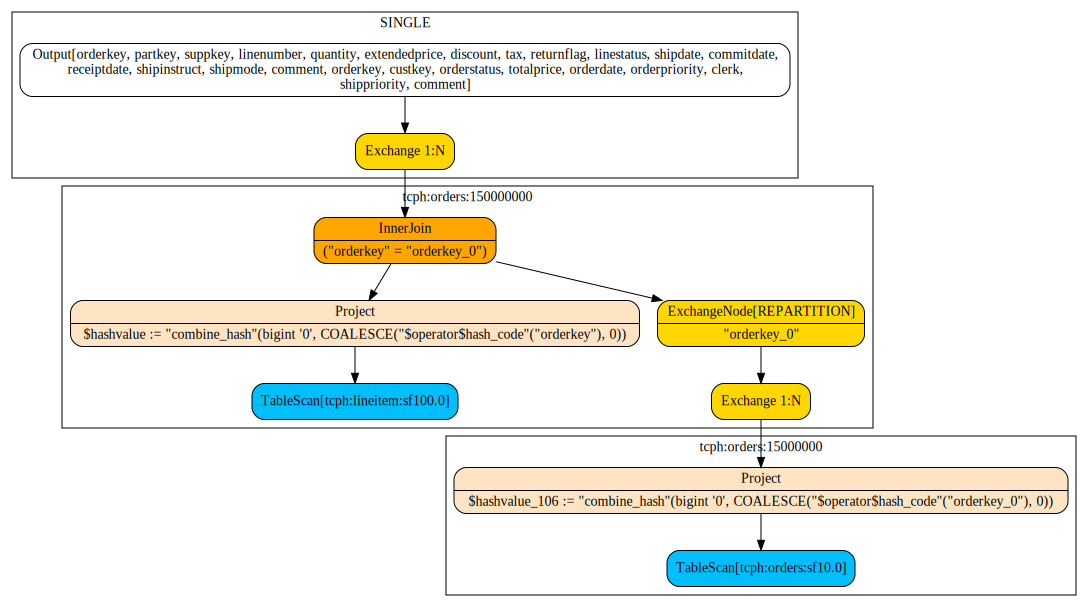

In [11]:
conn = presto.Connection(host="presto", port=8080, user="demo")
cur = conn.cursor()
cur.execute('''
SELECT
    l_orderkey,
    sum(l_extendedprice * (1 - l_discount)) as revenue,
    o_orderdate,
    o_shippriority
FROM
    pg2.public.pg_sf1_customer,
    pg3.public.pg_sf1_orders,
    pg3.public.pg_sf1_lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < date '1995-03-15'
    AND l_shipdate > date '1995-03-15'
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue desc,
    o_orderdate
LIMIT 10
''')
cur.fetchall()

In [18]:
results = drill.query('''SELECT
    l_orderkey,
    sum(l_extendedprice * (1 - l_discount)) as revenue,
    o_orderdate,
    o_shippriority
FROM
    pg2.public.pg_sf1_customer,
    pg3.public.pg_sf1_orders,
    pg3.public.pg_sf1_lineitem
WHERE
    c_mktsegment = 'BUILDING'
    AND c_custkey = o_custkey
    AND l_orderkey = o_orderkey
    AND o_orderdate < date '1995-03-15'
    AND l_shipdate > date '1995-03-15'
GROUP BY
    l_orderkey,
    o_orderdate,
    o_shippriority
ORDER BY
    revenue desc,
    o_orderdate
LIMIT 10''')

POST http://drill:8047/query.json [status:N/A request:10.009s]
Traceback (most recent call last):
  File "/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py", line 445, in _make_request
    six.raise_from(e, None)
  File "<string>", line 3, in raise_from
  File "/opt/conda/lib/python3.9/site-packages/urllib3/connectionpool.py", line 440, in _make_request
    httplib_response = conn.getresponse()
  File "/opt/conda/lib/python3.9/http/client.py", line 1347, in getresponse
    response.begin()
  File "/opt/conda/lib/python3.9/http/client.py", line 307, in begin
    version, status, reason = self._read_status()
  File "/opt/conda/lib/python3.9/http/client.py", line 268, in _read_status
    line = str(self.fp.readline(_MAXLINE + 1), "iso-8859-1")
  File "/opt/conda/lib/python3.9/socket.py", line 704, in readinto
    return self._sock.recv_into(b)
socket.timeout: timed out

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
 

ConnectionTimeout: ConnectionTimeout caused by - ReadTimeout(HTTPConnectionPool(host='drill', port=8047): Read timed out. (read timeout=10))

In [17]:
[result for result in results]

[{'c_custkey': '1',
  'c_phone': '25-989-741-2988',
  'c_acctbal': '711.56',
  'c_mktsegment': 'BUILDING  ',
  'c_address': 'IVhzIApeRb ot,c,E',
  'c_nationkey': '15',
  'c_name': 'Customer#000000001',
  'c_comment': 'to the even, regular platelets. regular, ironic epitaphs nag e'},
 {'c_custkey': '2',
  'c_phone': '23-768-687-3665',
  'c_acctbal': '121.65',
  'c_mktsegment': 'AUTOMOBILE',
  'c_address': 'XSTf4,NCwDVaWNe6tEgvwfmRchLXak',
  'c_nationkey': '13',
  'c_name': 'Customer#000000002',
  'c_comment': 'l accounts. blithely ironic theodolites integrate boldly: caref'},
 {'c_custkey': '3',
  'c_phone': '11-719-748-3364',
  'c_acctbal': '7498.12',
  'c_mktsegment': 'AUTOMOBILE',
  'c_address': 'MG9kdTD2WBHm',
  'c_nationkey': '1',
  'c_name': 'Customer#000000003',
  'c_comment': ' deposits eat slyly ironic, even instructions. express foxes detect slyly. blithely even accounts abov'},
 {'c_custkey': '4',
  'c_phone': '14-128-190-5944',
  'c_acctbal': '2866.83',
  'c_mktsegment': 'MA

Here we asked Presto to return the query plan in graphviz format.

Each box is a *stage* and the boundaries delimit when Presto has to exchange data between nodes.

## Create a Table in MySQL

Let's use the MySQL client to create the table. Then we will switch to Presto to manipulate the data:

In [ ]:
import MySQLdb

mysql = MySQLdb.connect(host="mysql", user="root", passwd="mysql")
cur = mysql.cursor()
cur.execute("CREATE DATABASE IF NOT EXISTS presto")
cur.fetchall()
cur.execute("""
    CREATE TABLE IF NOT EXISTS presto.events (event LONGTEXT)
    CHARSET utf8mb4 ENGINE=InnoDB
""")
cur.fetchall()
cur.execute("DESC presto.events")
for row in cur.fetchall():
    print("{table}: [{props}]".format(
        table=row[0],
        props=', '.join(str(i) for i in row[1:])))

## Load Data in MySQL

Let's now load data from [GH Archive](http://www.gharchive.org/) into MySQL and MongoDB.
Each file from GH Archive contains lines of JSON structs that represent events from the public GitHub timeline, for example repository creation or code push.

Now that the table is create in MySQL, we can insert rows with Presto by using the existing `conn` object created above. You can open http://localhost:8080 to see the execution Presto queries.

In [ ]:
import gzip
import io
import json
import re
import requests

# Load events happening between 4-5pm.
# Feel free to load more hours or more days.
# We limit the dataset to one hour here to not overload
# the machine that will run the queries as this tutorial
# is expected to run on a laptop.
# It is going to take some time. For the demo, i pre-loaded
# the data with the mysql client to avoid the overhead of creating
# Python objects.
zdata = requests.get("https://data.gharchive.org/2015-04-28-16.json.gz")
data = gzip.decompress(zdata.content)
rows = []

# load ``ROW_COUNT`` rows. Feel free to set a greater value if it
# works well in your environment. Using a small value on purpose
# to avoid loading data for a long time.
ROW_COUNT = 1000
cur = conn.cursor()
for n, line in enumerate(io.BytesIO(data)):
    row = line.strip().decode('utf8')
    sql = "INSERT INTO mysql.presto.events (event) VALUES ('{}')".format(row.replace("'", "''"))
    cur.execute(sql)
    cur.fetchall()
    if n == ROW_COUNT - 1:
        break

In [32]:
cur = conn.cursor()
cur.execute("SELECT json_extract(json_parse(event), '$.type') FROM mysql.presto.events TABLESAMPLE BERNOULLI (1) LIMIT 1")
cur.fetchall()

[['"CreateEvent"']]

In [3]:
cur = conn.cursor()
cur.execute("""
    SELECT ev_type, repo_name, count(*) FROM (
      SELECT
        TRY(json_extract_scalar(ev, '$.repo.name')) as repo_name,
        TRY(json_extract_scalar(ev, '$.type')) as ev_type FROM (
          SELECT try(json_parse(event)) as ev FROM mysql.presto.events))
    WHERE repo_name is not null and ev_type = 'PushEvent'
    GROUP BY ev_type, repo_name
    ORDER BY 3 DESC
    LIMIT 10
""")
rows = cur.fetchall()
import pandas as pd
from IPython.display import display

print(rows)
df = pd.DataFrame(sorted(rows, key=lambda x: x[2], reverse=True))
display(df)

[['PushEvent', 'pizzadealer/data', 25], ['PushEvent', 'sigma-1/kernel_samsung_lt03wifi', 5], ['PushEvent', 'wjcquking/fuzzyJoin', 3], ['PushEvent', 'EU-OSHA/napo', 3], ['PushEvent', 'Luiqes/My-Penguin', 2], ['PushEvent', 'Creadous/Creadous.github.io', 2], ['PushEvent', 'ashking/phnest', 2], ['PushEvent', 'baojianzhou/PyHW', 2], ['PushEvent', 'TenSheep/click-to-buy', 2], ['PushEvent', 'adrianvinuelas/X-Nav-OAuth-GitHub-Fichero', 2]]


,0,1,2
0,PushEvent,pizzadealer/data,25
1,PushEvent,sigma-1/kernel_samsung_lt03wifi,5
2,PushEvent,wjcquking/fuzzyJoin,3
3,PushEvent,EU-OSHA/napo,3
4,PushEvent,Luiqes/My-Penguin,2
5,PushEvent,Creadous/Creadous.github.io,2
6,PushEvent,ashking/phnest,2
7,PushEvent,baojianzhou/PyHW,2
8,PushEvent,TenSheep/click-to-buy,2
9,PushEvent,adrianvinuelas/X-Nav-OAuth-GitHub-Fichero,2


In [4]:
cur = conn.cursor()
cur.execute("CREATE TABLE mongodb.events.all AS SELECT * FROM mysql.presto.events")
cur.fetchall()

[[1001]]